In [7]:
import pandas as pd
NN = pd.read_csv('NN_importance2.csv')[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50]
lgb = pd.read_csv('LGBM_importance.csv')[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50]

In [8]:
NN.merge(lgb, left_index=True, right_index=True, how='inner')

,importance_x,importance_y
feature,,
EXT_SOURCE_3,0.033802,962.8
EXT_SOURCE_2,0.029313,896.7
EXT_SOURCE_1,0.005297,1002.9
APPROVED_CNT_PAYMENT_SUM,0.002040,200.7
DAYS_EMPLOYED_PERC,0.001827,364.5
PREV_CNT_PAYMENT_MEAN,0.001475,331.0
DAYS_BIRTH,0.001315,732.5
AMT_ANNUITY,0.001290,531.3
AMT_GOODS_PRICE,0.001063,318.6


In [57]:
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix, zero_one_score
import copy
import matplotlib.pyplot as plt
import itertools

ImportError: cannot import name 'zero_one_score' from 'sklearn.metrics' (/home/samyuen/.local/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

In [52]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('lgbm_confusion2.png')

In [32]:
y_pred = np.load('validation_pred.npy')
target = pd.read_csv('TARGET.csv').to_numpy().reshape(-1,1)

In [111]:
temp_pred = copy.deepcopy(y_pred)
temp_pred[temp_pred >= 0.075] = 1
temp_pred[temp_pred < 0.075] = 0
print(classification_report(target, temp_pred, output_dict=False))

              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82    282682
         1.0       0.18      0.73      0.29     24825

    accuracy                           0.71    307507
   macro avg       0.57      0.72      0.56    307507
weighted avg       0.90      0.71      0.78    307507



Confusion matrix, without normalization
[[201173  81509]
 [  6709  18116]]


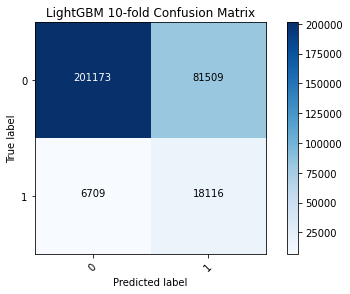

In [112]:
cm = confusion_matrix(target, temp_pred)
plot_confusion_matrix(cm, [0,1], False, 'LightGBM 10-fold Confusion Matrix')

In [60]:
cm

array([[281626,   1056],
       [ 23464,   1361]])

In [68]:
thresholds = np.arange(0,1,1/200)
highest_roc = 0
best_threshold = None
err_rate0 = []
err_rate1 = []
for threshold in tqdm(thresholds):
    #print(threshold)
    temp_pred = copy.deepcopy(y_pred)
    temp_pred[temp_pred >= threshold] = 1
    temp_pred[temp_pred < threshold] = 0
    '''if roc > highest_roc:
        highest_roc = roc
        best_threshold = threshold'''
    
    result = classification_report(target, temp_pred, output_dict=True)
    cm = confusion_matrix(target, temp_pred)
    err_rate0.append(cm[0][1]/(np.sum(cm[0])))
    err_rate1.append(cm[1][0]/(np.sum(cm[1])))
    '''print('specificity of 0:', result['0.0']['recall'], 'sensitivity of 1:', result['1.0']['recall'])
    print('precision of 0:', result['0.0']['precision'], 'precision of 1:', result['1.0']['precision'])
    print('f1-score of 0:', result['0.0']['f1-score'], 'f1-score of 1:', result['1.0']['f1-score'])'''

100%|██████████| 200/200 [01:53<00:00,  1.77it/s]


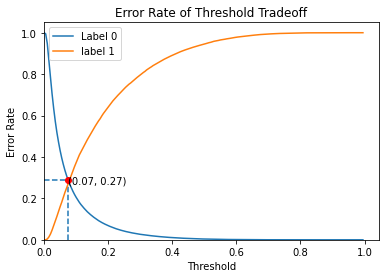

In [118]:
err_rate0 = np.array(err_rate0)
err_rate1 = np.array(err_rate1)
plt.plot(thresholds, err_rate0, '-', label='Label 0')
plt.plot(thresholds, err_rate1, '-', label='label 1')
idx = np.argwhere(np.diff(np.sign(err_rate0 - err_rate1))).flatten()
plt.plot(thresholds[idx], err_rate0[idx], 'ro')
plt.vlines(thresholds[idx], 0, err_rate0[idx], linestyle="dashed")
plt.hlines(err_rate0[idx], 0, thresholds[idx], linestyle="dashed")
plt.ylabel('Error Rate')
plt.xlabel('Threshold')
plt.xlim(0,None)
plt.ylim(0,None)
#plt.text(thresholds[idx], err_rate0[idx], '({}, {})'.format(np.round(thresholds[idx],2), np.around(err_rate0[idx],2)))
plt.annotate('(%.2f, %.2f)' % (thresholds[idx], err_rate1[idx]), xy=(thresholds[idx], err_rate1[idx]))
plt.legend()
plt.title('Error Rate of Threshold Tradeoff')
plt.savefig('tradeoff.png')

In [107]:
 thresholds[idx]

array([0.075])

In [117]:
err_rate1[idx]

array([0.27025176])